In [1]:
# Set up the default parameters
# 1. The code block will be shown in the document
# 2. set up figure display size
# 3. turn off all the warnings and messages

knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.width = 8, fig.height = 4)
knitr::opts_chunk$set(warning = FALSE, message = FALSE)


## Background

Individuals stock prices tend to exhibit high amounts of non-constant variance, and thus ARIMA models build upon that data would likely exhibit non-constant variance in residuals. In this problem we are going to analyze the Intel stock price data from 2012 through end of 2021. We will use the ARIMA-GARCH to model daily and weekly stock price (adjusted close price at the end of a day for daily data or at the end of the week for weekly data), with a focus on the behavior of its volatility as well as forecasting both the price and the volatility.

##Data import and cleaning


In [2]:
## Libraries used within this homework are uploaded here
library(zoo,warn.conflicts=FALSE)
library(lubridate,warn.conflicts=FALSE)
library(mgcv,warn.conflicts=FALSE)
library(rugarch,warn.conflicts=FALSE)
library(ggplot2)

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘rugarch’ was built under R version 4.0.5”
Loading required package: parallel

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar



In [3]:
#importing the data
dailydata <- read.csv("INTCDaily.csv", head = TRUE)
weeklydata <- read.csv("INTCWeekly.csv", head = TRUE)
#cleaning the data
#dates to date format
weeklydata$Date<-as.Date(weeklydata$Date,format='%m/%d/%y')
dailydata$Date<-as.Date(dailydata$Date,format='%m/%d/%y')

#prices to timeseries format
INTWeekly <- ts(weeklydata$Adj.Close,start=c(2012,1,1),freq=52)
INTDaily <- ts(dailydata$Adj.Close,start=c(2012,1,1),freq=252)
 

# Question 1: Exploratory Data Analysis (20 points)

**1a.** Based on your intuition, when would you use daily vs weekly stock price data?

*Response: Question 1a*

Daily stock price data is expected to experience more changes and be more chaotic than the weekly data. I would use the daily data if the goal was to predict future trends on a daily basis. Likewise, I would use weekly data if the expectations were for predictions to be at the weekly granularity. 

**1b.** Plot the time series plots  comparing daily vs weekly data. How do the daily vs weekly time series data compare?

Warning message:
“Removed 2265 row(s) containing missing values (geom_path).”
Warning message:
“Removed 470 row(s) containing missing values (geom_path).”


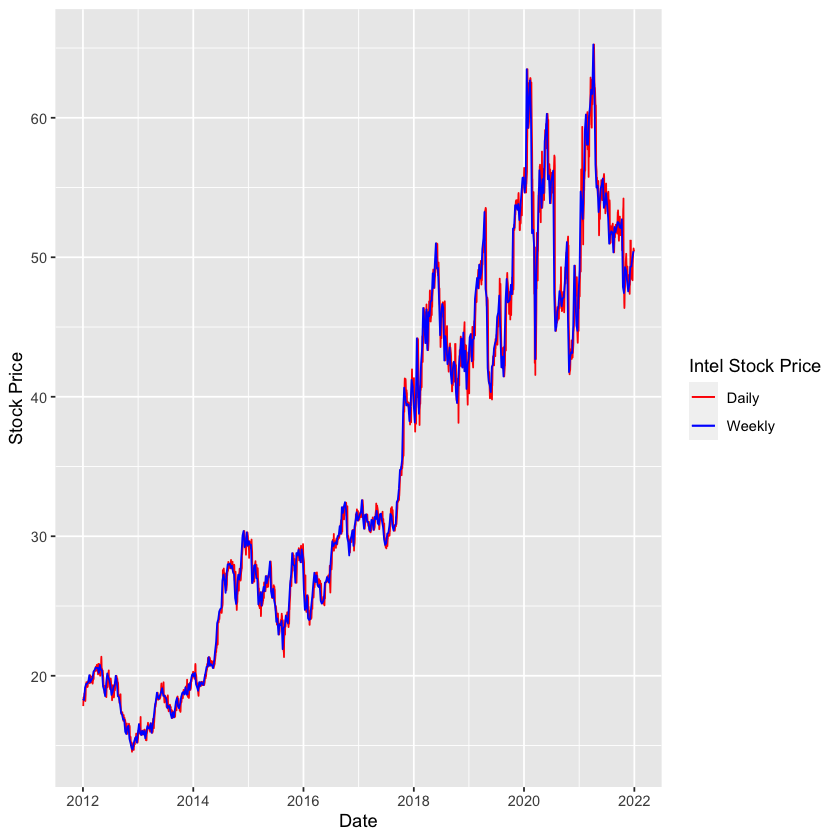

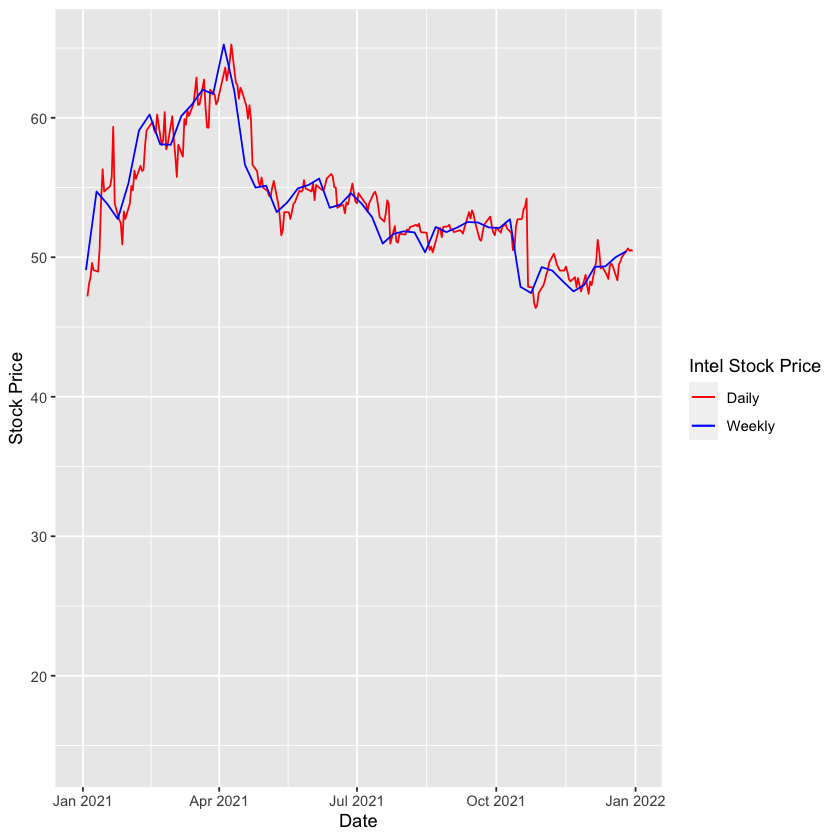

In [4]:
ggplot() + 
  geom_line(data = dailydata, aes(x = Date, y = Adj.Close, color="Daily")) +
  geom_line(data = weeklydata, aes(x = Date, y = Adj.Close, color = "Weekly")) +
  xlab('Date') +
  ylab('Stock Price') + scale_color_manual(name='Intel Stock Price',
                     breaks=c('Daily', 'Weekly'),
                     values=c('Daily'='red', 'Weekly'='blue'))

ggplot() + 
  geom_line(data = dailydata, aes(x = Date, y = Adj.Close, color="Daily")) +
  geom_line(data = weeklydata, aes(x = Date, y = Adj.Close, color = "Weekly")) +
  xlab('Date') + xlim(as.Date(c('2021-01-01','2021-12-31'))) +
  ylab('Stock Price') + scale_color_manual(name='Intel Stock Price',
                     breaks=c('Daily', 'Weekly'),
                     values=c('Daily'='red', 'Weekly'='blue'))

*Response: Question 1b*

As expected the weekly data is a smoothed version of the daily data. The weekly data doesn't expereience the peaks and valleys experienced by the daily data but does follow the same trend. To show this phenomena clearly I plotted the data just for calendar year 2021.

**1c.** Fit a non-parametric trend using splines regression to both the daily and weekly time-series data. Overlay the fitted trends. How do the trends compare?

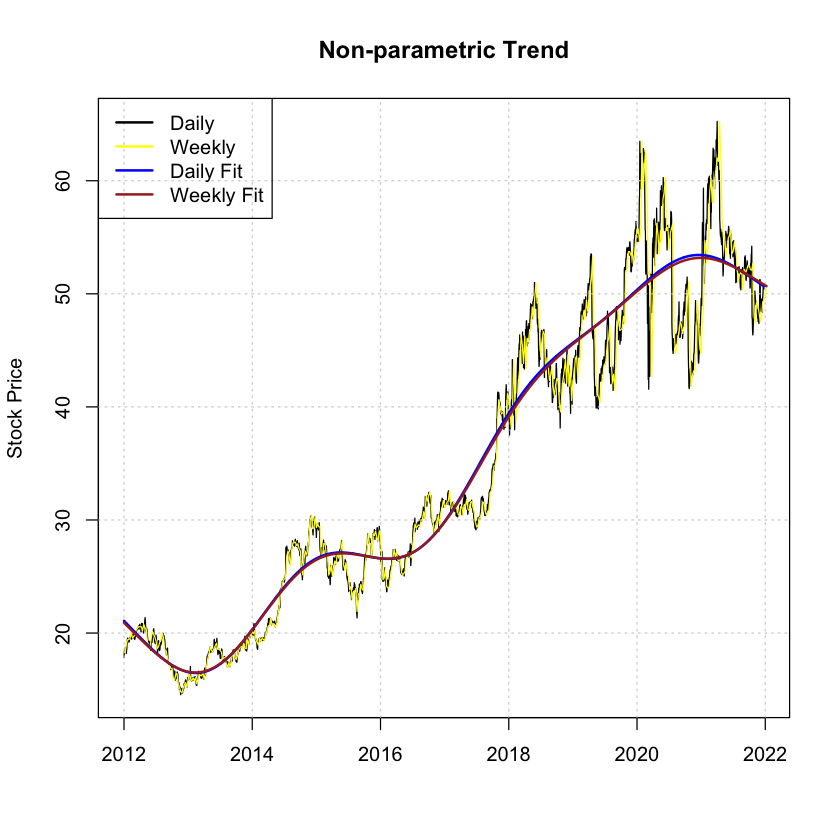

In [6]:
# Daily Data

points_daily <- 1:nrow(dailydata)
points_daily <- (points_daily - min(points_daily)) / max(points_daily)

gam.w.daily <- gam(INTDaily ~ s(points_daily))
gam.w.daily.fit <- ts(fitted(gam.w.daily), start=c(2012,1,1),freq=252)

# Weekly Data

points_weekly <- 1:nrow(weeklydata)
points_weekly <- (points_weekly - min(points_weekly)) / max(points_weekly)

gam.w.weekly <- gam(INTWeekly ~ s(points_weekly))
gam.w.weekly.fit <- ts(fitted(gam.w.weekly), start=c(2012,1,1),freq=52)

# Plot
ts.plot(INTDaily, xlab = "", ylab = "Stock Price",
        main = "Non-parametric Trend")
grid()
lines(INTWeekly, col="yellow")
lines(gam.w.daily.fit, lwd=2, col="blue")
lines(gam.w.weekly.fit, lwd=2, col="brown")
legend("topleft", legend = c("Daily", "Weekly", "Daily Fit", "Weekly Fit"),
col = c("black", "yellow", "blue", "brown"), lwd = 2)

*Response: Question 1c*

The trends of the weekly and daily data follow very closely together. They do deviate slightly from 2018 to 2022 in times of high volitility.

**1d.** Consider the return stock price computed as provided in the canvas homework assignment. 
Apply this formula to compute the return price based on the daily and weekly time series data. Plot the return time series and their corresponding ACF plots. How do the return time series compare in terms of stationarity and serial dependence?

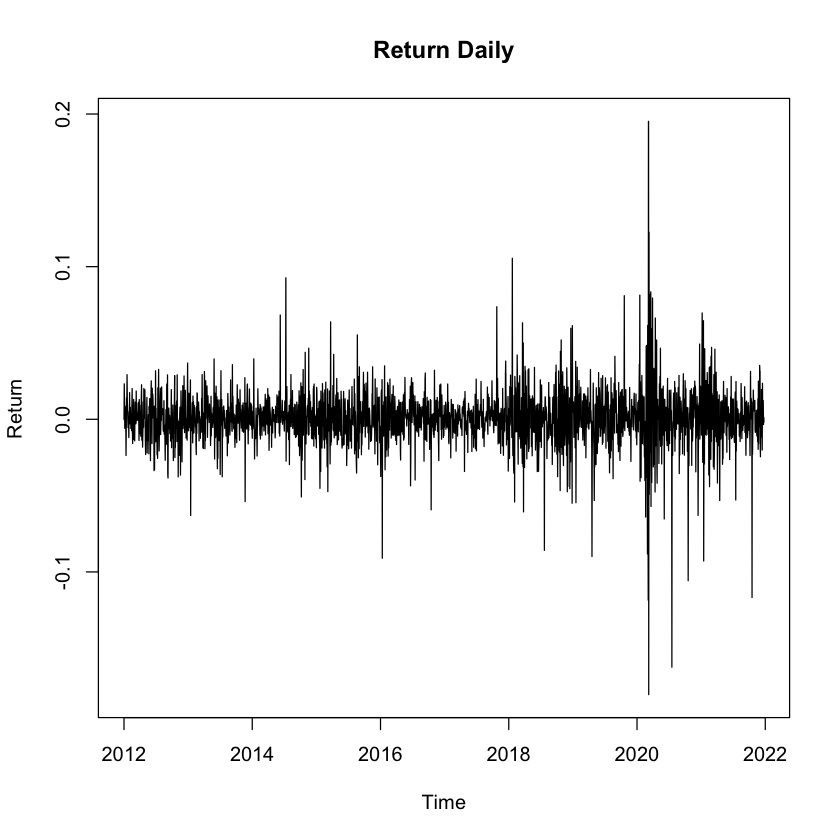

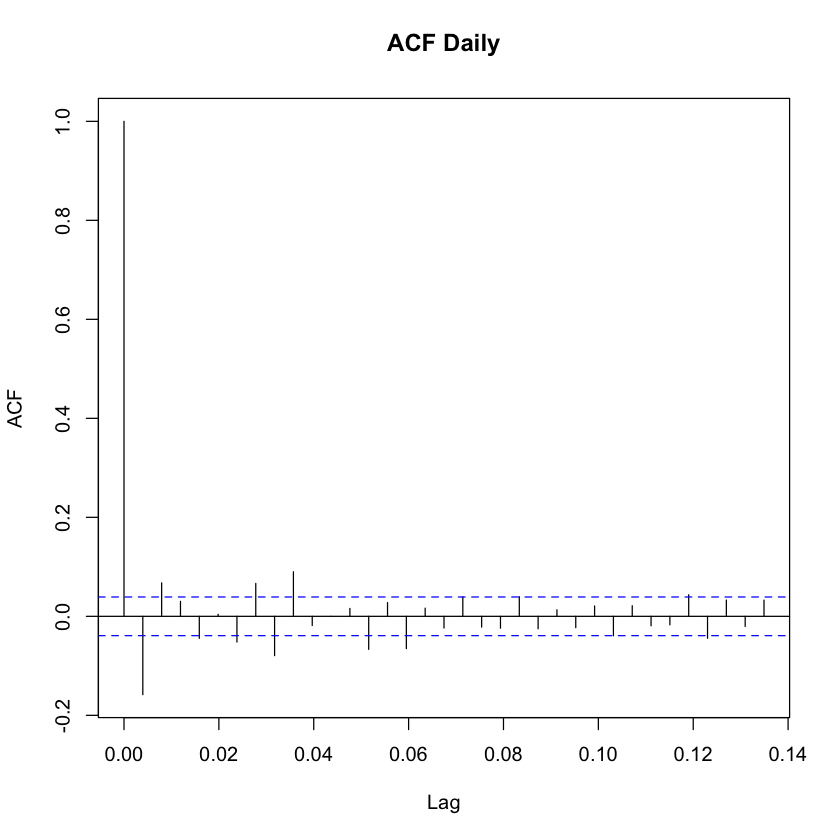

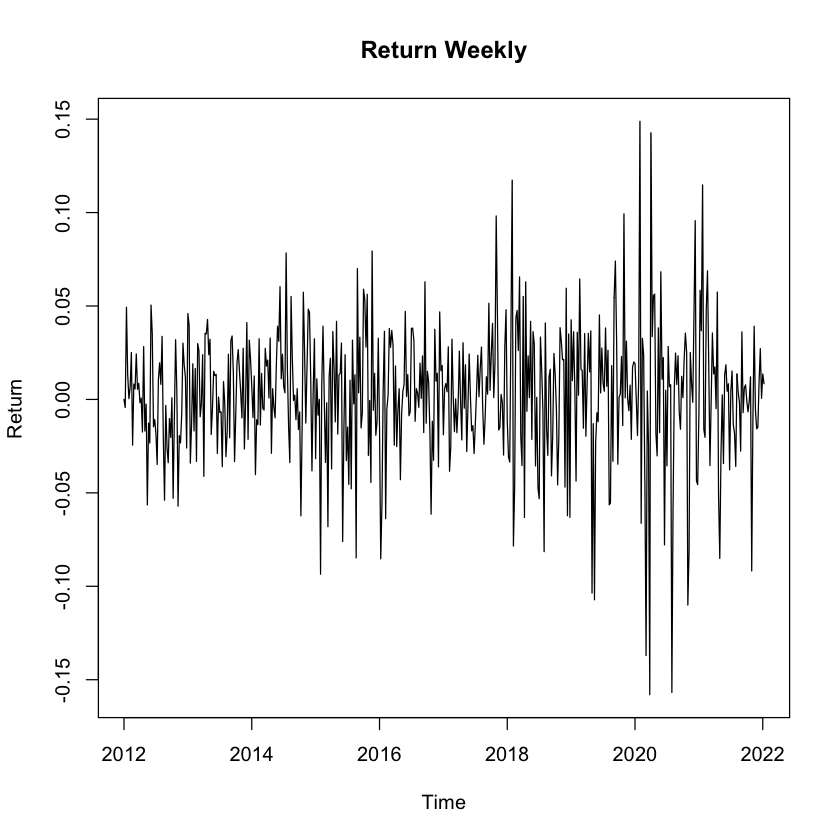

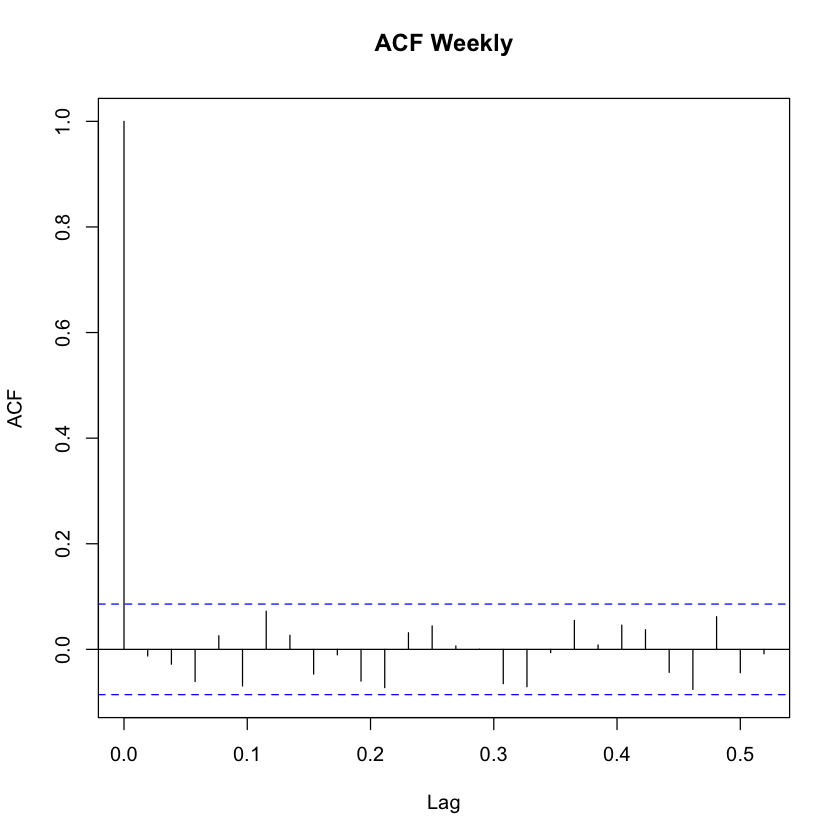

In [9]:
# Calculate return of daily
returnDaily <- diff(INTDaily) / INTDaily[- length(INTDaily)]
returnDaily <- c(0,returnDaily)
returnDaily.ts <- ts(returnDaily, start = c(2012, 1, 1), frequency = 252)

plot.ts(returnDaily.ts, main="Return Daily", ylab="Return")
acf(returnDaily.ts, main="ACF Daily")

#Calculate return of weekly
returnWeekly <- diff(INTWeekly) / INTWeekly[- length(INTWeekly)]
returnWeekly <- c(0,returnWeekly)
returnWeekly.ts <- ts(returnWeekly, start = c(2012, 1, 1), frequency = 52)

plot.ts(returnWeekly.ts, main="Return Weekly", ylab="Return")
acf(returnWeekly.ts, main="ACF Weekly")

*Response: Question 1d*

Both datasets show some cyclic pattern. The daily datasets exhibits some ACF lags outside the confidence bands. However the weekly dataset shows a weakly stationary process because no lags are outside the confidence bands.

# Question 2: ARIMA(p,d,q) for Stock Price (20 Points)

**2a.** Divide the data into training and testing data set, where the training data exclude the last week of data (December 27th - December 30th) with the testing data including the last week of data. Apply the iterative model to fit an ARIMA(p,d,q) model with max AR and MA orders of 8 and difference orders 1 and 2 separately to the training datasets of the daily and weekly data. Display the summary of the final model fit.

In [10]:
# Create ARIMA fit function

arimafitfunction <- function(datatrain, norderpq, norderd) {

p = c(1:norderpq)-1; q = c(1:norderpq)-1; d = c(1:norderd)

aic1 = matrix(0, norderpq, norderpq)
aic2 = matrix(0, norderpq, norderpq)

for (i in 1:norderpq){
    for (j in 1:norderpq){
        for (k in 1:norderd){
            modijk = arima(datatrain$Adj.Close, order = c(p[i], d[k], q[j]), method = 'ML')
            if (k == 1){
                aic1[i,j] = modijk$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*length(daily.w.train)/(length(daily.w.train)-p[i]-q[j]-2)
            } else {
                aic2[i,j] = modijk$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*length(daily.w.train)/(length(daily.w.train)-p[i]-q[j]-2)
            }
        }
    }
}

aicv1 = as.vector(aic1)
indexp1 = rep(c(1:norderpq),norderpq)
indexq1 = rep(c(1:norderpq),each=norderpq)
indexaic1 = which(aicv1 == min(aicv1))
porder1 = indexp1[indexaic1]-1
qorder1 = indexq1[indexaic1]-1

minaic1 = aic1[porder1+1,qorder1+1]

aicv2 = as.vector(aic2)
indexp2 = rep(c(1:norderpq),norderpq)
indexq2 = rep(c(1:norderpq),each=norderpq)
indexaic2 = which(aicv2 == min(aicv2))
porder2 = indexp2[indexaic2]-1
qorder2 = indexq2[indexaic2]-1

minaic2 = aic1[porder2+1,qorder2+1]

if (minaic1 < minaic2){
    arima = arima(datatrain$Adj.Close, order = c(porder1, 1, qorder1), method = 'ML')
    d = 1
    p = porder1
    q = qorder1
} else {
    arima = arima(datatrain$Adj.Close, order = c(porder2, 2, qorder2), method = 'ML')
    d = 2
    p = porder2
    q = qorder2
}

 return(list(arima=arima, p=p, q=q, d=d))
}

In [11]:
options(warn = -1)
numdaily <- 4
numweekly <- 1
# set up the training and testing data
daily.w.train <- head(dailydata, n=length(dailydata$Date)-numdaily)
daily.w.test <-tail(dailydata, n=numdaily)
weekly.w.train <- head(weeklydata, n=length(weeklydata$Date)-numweekly)
weekly.w.test <- tail(weeklydata, n=numweekly)

In [12]:
arima.daily = arimafitfunction(daily.w.train, 8, 2)
arima.daily$arima


Call:
arima(x = datatrain$Adj.Close, order = c(porder1, 1, qorder1), method = "ML")

Coefficients:
          ar1     ar2     ar3      ar4      ar5     ar6     ar7    ma1      ma2
      -0.5843  0.2644  0.4196  -0.1513  -0.0796  0.4091  0.5718  0.428  -0.2667
s.e.   0.1416  0.1997  0.1053   0.1641   0.1389  0.0963  0.0821  0.143   0.1796
          ma3     ma4      ma5      ma6      ma7
      -0.2803  0.1777  -0.0217  -0.4834  -0.4819
s.e.   0.0955  0.1363   0.1156   0.0922   0.0936

sigma^2 estimated as 0.5793:  log likelihood = -2877.86,  aic = 5785.72

In [13]:
arima.weekly = arimafitfunction(weekly.w.train, 8, 2)
arima.weekly$arima


Call:
arima(x = datatrain$Adj.Close, order = c(porder1, 1, qorder1), method = "ML")

Coefficients:
          ar1      ar2     ar3      ar4     ar5     ar6     ar7      ma1
      -0.0052  -0.4225  0.2174  -0.4373  0.3024  0.3518  0.3817  -0.0139
s.e.   0.2229   0.3077  0.2026   0.1361  0.2277  0.2852     NaN   0.2059
         ma2      ma3     ma4      ma5      ma6      ma7
      0.4102  -0.2529  0.4601  -0.4826  -0.3479  -0.4352
s.e.  0.3213   0.1975  0.1308   0.2375   0.3424      NaN

sigma^2 estimated as 2.17:  log likelihood = -941.71,  aic = 1913.43

**2b.** Evaluate the model residuals and squared residuals using the ACF and PACF plots as well as hypothesis testing for serial correlation. What would you conclude based on this analysis?


	Box-Pierce test

data:  arima.daily$arima$resid
X-squared = 3.8337, df = 1, p-value = 0.05023



	Box-Ljung test

data:  arima.daily$arima$resid
X-squared = 3.8512, df = 1, p-value = 0.04971


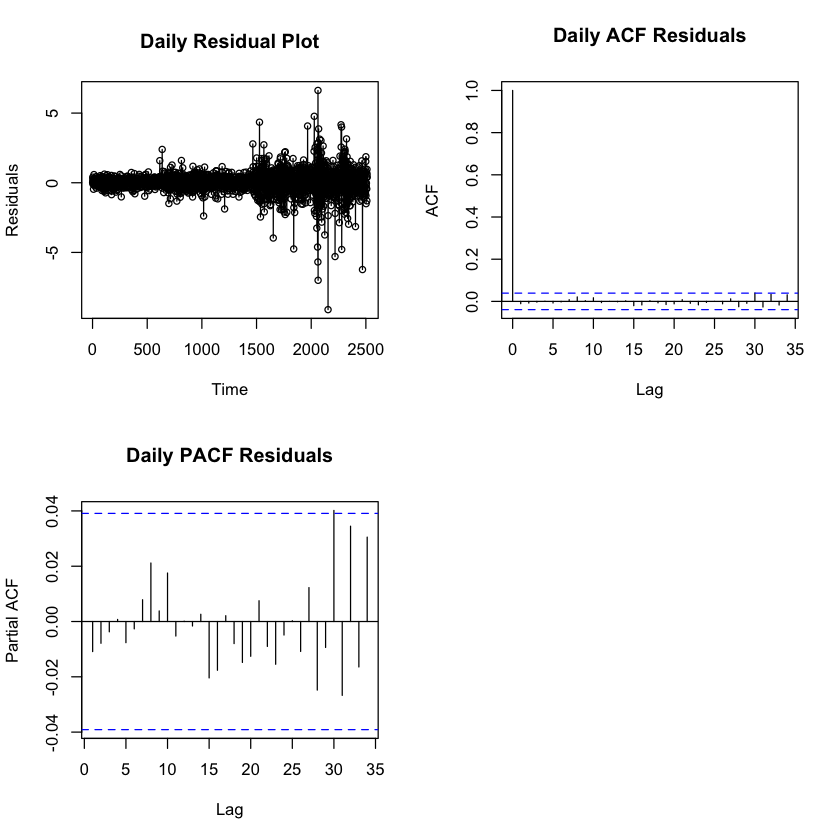

In [14]:
par(mfrow = c(2, 2))
plot(arima.daily$arima$resid, ylab="Residuals", type = "o", main = "Daily Residual Plot")
acf(arima.daily$arima$resid, main = "Daily ACF Residuals")
pacf(arima.daily$arima$resid, main = "Daily PACF Residuals")

Box.test(arima.daily$arima$resid, lag = (arima.daily$p+arima.daily$q+1), type="Box-Pierce", fitdf=(arima.daily$p+arima.daily$q))
Box.test(arima.daily$arima$resid, lag = (arima.daily$p+arima.daily$q+1), type="Ljung-Box", fitdf=(arima.daily$p+arima.daily$q))


	Box-Pierce test

data:  arima.weekly$arima$resid
X-squared = 5.077, df = 1, p-value = 0.02424



	Box-Ljung test

data:  arima.weekly$arima$resid
X-squared = 5.1979, df = 1, p-value = 0.02261


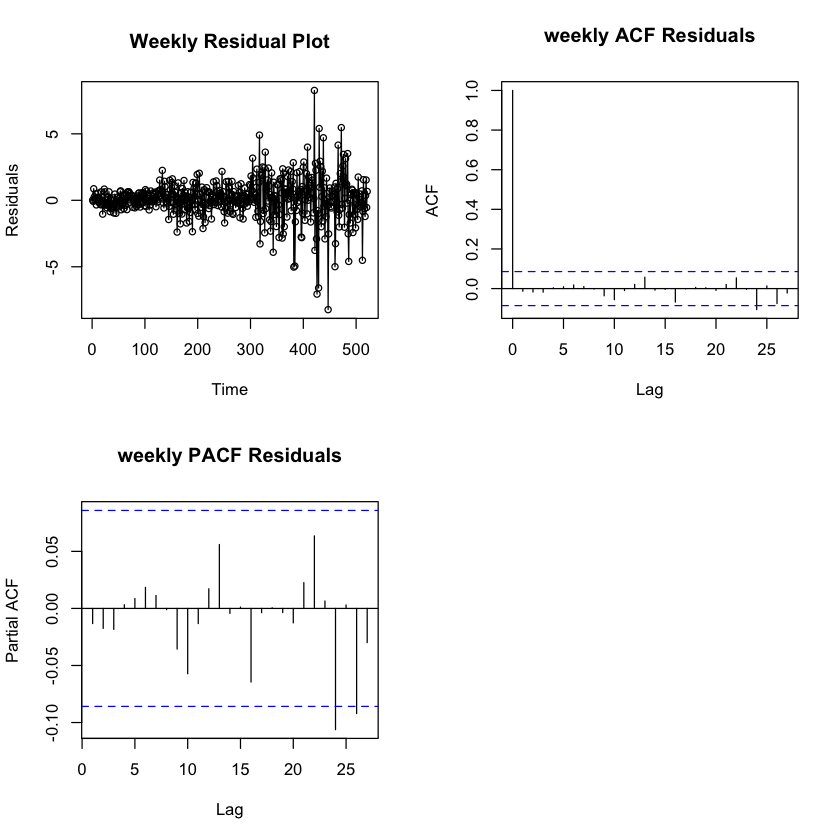

In [15]:
par(mfrow = c(2, 2))
plot(arima.weekly$arima$resid, ylab="Residuals", type = "o", main = "Weekly Residual Plot")
acf(arima.weekly$arima$resid, main = "weekly ACF Residuals")
pacf(arima.weekly$arima$resid, main = "weekly PACF Residuals")

Box.test(arima.weekly$arima$resid, lag = (arima.weekly$p+arima.weekly$q+1), type="Box-Pierce", fitdf=(arima.weekly$p+arima.weekly$q))
Box.test(arima.weekly$arima$resid, lag = (arima.weekly$p+arima.weekly$q+1), type="Ljung-Box", fitdf=(arima.weekly$p+arima.weekly$q))

*Response: Question 2b*

**2c.** Apply the model identified in (2a) and forecast the last week of data. Plot the predicted data to compare the predicted values to the actual observed ones. Include 95% confidence intervals for the forecasts in the corresponding plots.

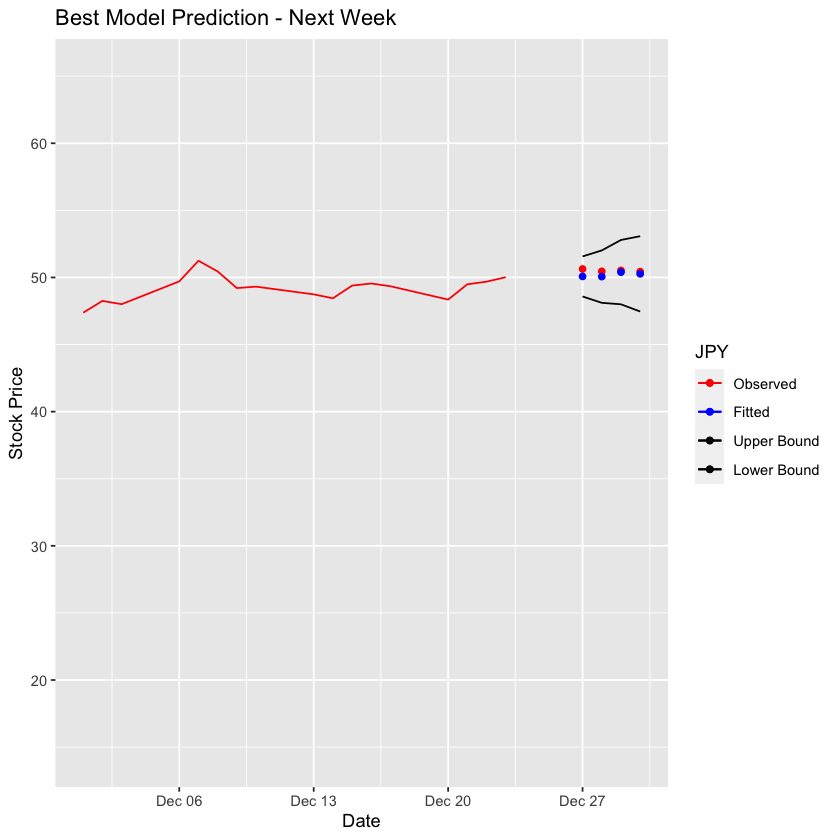

In [21]:
# Daily Data
outpred.daily <- predict(arima.daily$arima, n.ahead = 4) # 95% confidence interval
ubound.daily <- outpred.daily$pred + 1.96 * outpred.daily$se
lbound.daily <- outpred.daily$pred - 1.96 * outpred.daily$se
ggplot() + 
  geom_line(data = daily.w.train, aes(x = Date, y = Adj.Close, color="Observed")) +
  geom_point(data = daily.w.test, aes(x = Date, y = Adj.Close, color = "Observed")) +
  geom_point(data = daily.w.test, aes(x = Date, y = outpred.daily$pred, color = "Fitted")) +
  geom_line(data = daily.w.test, aes(x = Date, y = ubound.daily, color="Upper Bound")) +
  geom_line(data = daily.w.test, aes(x = Date, y = lbound.daily, color="Lower Bound")) +
  xlab('Date') + xlim(as.Date(c('2021-12-01',max(dailydata$Date)))) +
  ylab('Stock Price') + labs(title = 'Best Model Prediction - Next Week') + scale_color_manual(name='JPY',
                     breaks=c('Observed', 'Fitted', 'Upper Bound', 'Lower Bound'),
                     values=c('Observed'='red', 'Fitted'='blue', 'Upper Bound' = 'black', 'Lower Bound'='black'))

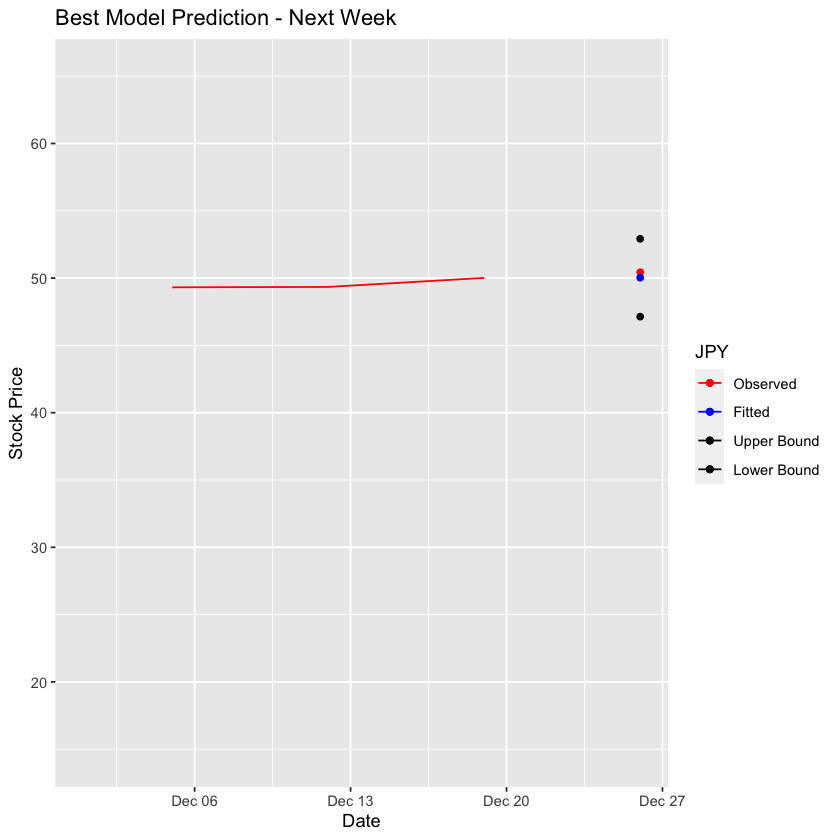

In [22]:
# Weekly Data
outpred.weekly <- predict(arima.weekly$arima, n.ahead = 1) # 90% confidence interval
ubound.weekly <- outpred.weekly$pred + 1.96 * outpred.weekly$se
lbound.weekly <- outpred.weekly$pred - 1.96 * outpred.weekly$se
ggplot() + 
  geom_line(data = weekly.w.train, aes(x = Date, y = Adj.Close, color="Observed")) +
  geom_point(data = weekly.w.test, aes(x = Date, y = Adj.Close, color = "Observed")) +
  geom_point(data = weekly.w.test, aes(x = Date, y = outpred.weekly$pred, color = "Fitted")) +
  geom_point(data = weekly.w.test, aes(x = Date, y = ubound.weekly, color="Upper Bound")) +
  geom_point(data = weekly.w.test, aes(x = Date, y = lbound.weekly, color="Lower Bound")) +
  xlab('Date') + xlim(as.Date(c('2021-12-01',max(weeklydata$Date)))) +
  ylab('Stock Price') + labs(title = 'Best Model Prediction - Next Week') + scale_color_manual(name='JPY',
                     breaks=c('Observed', 'Fitted', 'Upper Bound', 'Lower Bound'),
                     values=c('Observed'='red', 'Fitted'='blue', 'Upper Bound' = 'black', 'Lower Bound'='black'))

**2d.** Calculate Mean Absolute Percentage Error (MAPE) and Precision Measure (PM) (PM only for daily data). How many observations are within the prediction bands?  Compare the accuracy of the predictions for the daily and weekly time series using these two measures.  

In [24]:
# Daily
## MAPE
MAPE.Daily = mean(abs(outpred.daily$pred-daily.w.test$Adj.Close)/daily.w.test$Adj.Close)
paste("The MAPE of the daily prediction is:", round(MAPE.Daily, 3))
## PM
PM.Daily = sum((outpred.daily$pred-daily.w.test$Adj.Close)^2)/sum((daily.w.test$Adj.Close-mean(daily.w.test$Adj.Close))^2)
paste("The PM of the daily prediction is:", round(PM.Daily, 3))

[1] "The MAPE of the daily prediction is: 0.006"

[1] "The PM of the daily prediction is: 21.898"

In [27]:
# Weekly
## MAPE
MAPE.weekly = mean(abs(outpred.weekly$pred-weekly.w.test$Adj.Close)/weekly.w.test$Adj.Close)
paste("The MAPE of the weekly prediction is:", round(MAPE.weekly, 3))
## PM
PM.weekly = sum((outpred.weekly$pred-weekly.w.test$Adj.Close)^2)/sum((weekly.w.test$Adj.Close-mean(weekly.w.test$Adj.Close))^2)
paste("The PM of the weekly prediction is:", round(PM.weekly, 3))

[1] "The MAPE of the weekly prediction is: 0.008"

[1] "The PM of the weekly prediction is: Inf"

The instructions stated to only predict the last week. The resulting forecast for the daily dataset is 4 days. However there is only 1 data point for the weekly data. The results are difficult to compare for this reason. The PM metric always be infinite becasue the mean of one number is the same number, resulting in 0 in the denomerator of the PM metric.

For what its worth the MAPE value is lower for the daily data indicating this model fits the model better.

# Question 3: ARMA(p,q)-GARCH(m,n) for Return Stock Price (20 Points)

**3a.** Divide the data into training and testing data set, where the training data exclude the last week of data (December 27th - December 30th) with the testing data including the last week of data. Apply the iterative model to fit an ARMA(p,q)-GARCH(m,n) model by selecting the orders for p & q up to 5 and orders for m & n up to 2. Display the summary of the final model fit. Write up the equation of the estimated model.

In [46]:
# Divide data into daily and weekly train and test

numdaily <- 4
numweekly <- 1
# set up the training and testing data
daily.w.train <- head(dailydata, n=length(dailydata$Date)-numdaily)
daily.w.test <-tail(dailydata, n=numdaily)
weekly.w.train <- head(weeklydata, n=length(weeklydata$Date)-numweekly)
weekly.w.test <- tail(weeklydata, n=numweekly)

# Fit garch using fixed arma model

test_modelAGG <- function(data,m,n){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(5,5),
                                      include.mean=T),
                      distribution.model="std")
    fit = ugarchfit(spec, data, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(m,n,current.bic)
    names(df) <- c("m","n","BIC")
    print(paste(m,n,current.bic,sep=" "))
    return(df)
}


ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
    for (n in 0:2){
        possibleError <- tryCatch(
            ordersAGG<-rbind(ordersAGG,test_modelAGG(daily.w.train$Adj.Close,m,n)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

[1] "0 0 1.72094543291288"
[1] "0 1 1.61280964192549"
[1] "0 2 1.59185836980609"
[1] "1 0 1.57435899652589"
[1] "1 1 1.40115095867256"
[1] "1 2 1.40228707994689"
[1] "2 0 1.51613389491883"
[1] "2 1 1.40200706152546"
[1] "2 2 1.4054061050508"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
5,1,0,1.574359
8,2,0,1.516134
10,2,2,1.405406
7,1,2,1.402287
9,2,1,1.402007
6,1,1,1.401151


In [48]:
#ARMA update
#ARIMA-GARCH: Select ARIMA order
test_modelAGA <- function(data,p,q){
    spec = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                      mean.model=list(armaOrder=c(p,q),
                                      include.mean=T),
                      distribution.model="std")
    fit = ugarchfit(spec, data, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(p,q,current.bic)
    names(df) <- c("p","q","BIC")
    print(paste(p,q,current.bic,sep=" "))
    return(df)
}

ordersAGA = data.frame(Inf,Inf,Inf)
names(ordersAGA) <- c("p","q","BIC")
for (p in 0:5){
    for (q in 0:5){
        possibleError <- tryCatch(
            ordersAGA<-rbind(ordersAGA,test_modelAGA(daily.w.train$Adj.Close,p,q)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGA <- ordersAGA[order(-ordersAGA$BIC),]
tail(ordersAGA)

[1] "0 0 6.86203078264402"
[1] "0 1 5.75253330727302"
[1] "0 2 4.91929461848626"
[1] "0 3 4.28672065378463"
[1] "0 4 3.85319244735943"
[1] "0 5 3.47892539303506"
[1] "1 0 1.37792195543102"
[1] "1 1 1.38034228844073"
[1] "1 2 1.38348059660009"
[1] "1 3 1.38690738420753"
[1] "1 4 1.3905093398829"
[1] "1 5 1.39346146783363"
[1] "2 0 1.37800599182837"
[1] "2 1 1.38100294003319"
[1] "2 2 1.38387032165001"
[1] "2 3 1.3867988546924"
[1] "2 4 1.3902995837817"
[1] "2 5 1.39379095510267"
[1] "3 0 1.38148430222917"
[1] "3 1 1.38254963934757"
[1] "3 2 1.38372128366185"
[1] "3 3 1.38788810499936"
[1] "3 4 1.394027609797"
[1] "3 5 1.3967744247904"
[1] "4 0 1.38506146172774"
[1] "4 1 1.38715108341876"
[1] "4 2 1.39010431166696"
[1] "4 3 1.3925789186347"
[1] "4 4 1.39722503689513"
[1] "4 5 1.39555983333789"
[1] "5 0 1.38878910464755"
[1] "5 1 1.39038468110283"
[1] "5 2 1.3927958733532"
[1] "5 3 1.39527075556242"
[1] "5 4 1.38771908754813"
[1] "5 5 1.40115095867256"


,p,q,BIC
,<dbl>,<dbl>,<dbl>
21,3,1,1.382550
20,3,0,1.381484
15,2,1,1.381003
9,1,1,1.380342
14,2,0,1.378006
8,1,0,1.377922


In [49]:
#GARCH update
test_modelAGG <- function(data,m,n){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(1,0),
                                      include.mean=T), distribution.model="std")
    fit = ugarchfit(spec, data, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(m,n,current.bic)
    names(df) <- c("m","n","BIC")
    print(paste(m,n,current.bic,sep=" "))
    return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
    for (n in 0:2){
        possibleError <- tryCatch(
            ordersAGG<-rbind(ordersAGG,test_modelAGG(daily.w.train$Adj.Close,m,n)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)
# Final ARMA(1,0)+GARCH(1,1) selected 

[1] "0 0 1.70924658730058"
[1] "0 1 1.60017690088139"
[1] "0 2 1.57847033340932"
[1] "1 0 1.57961646055123"
[1] "1 1 1.37792195543102"
[1] "1 2 1.37933590755965"
[1] "2 0 1.51566515933416"
[1] "2 1 1.38155822062379"
[1] "2 2 1.38245252980259"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
4,0,2,1.578470
8,2,0,1.515665
10,2,2,1.382453
9,2,1,1.381558
7,1,2,1.379336
6,1,1,1.377922


In [53]:
spec = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                 mean.model=list(armaOrder=c(1, 0),
                 include.mean=T), distribution.model="std")
garch.arma.model = ugarchfit(spec, daily.w.train$Adj.Close, solver = 'hybrid')

*Response: Question 3a*

**3b.** Evaluate the model residuals and squared residuals using the ACF and PACF plots as well as hypothesis testing for serial correlation. What would you conclude based on this analysis?

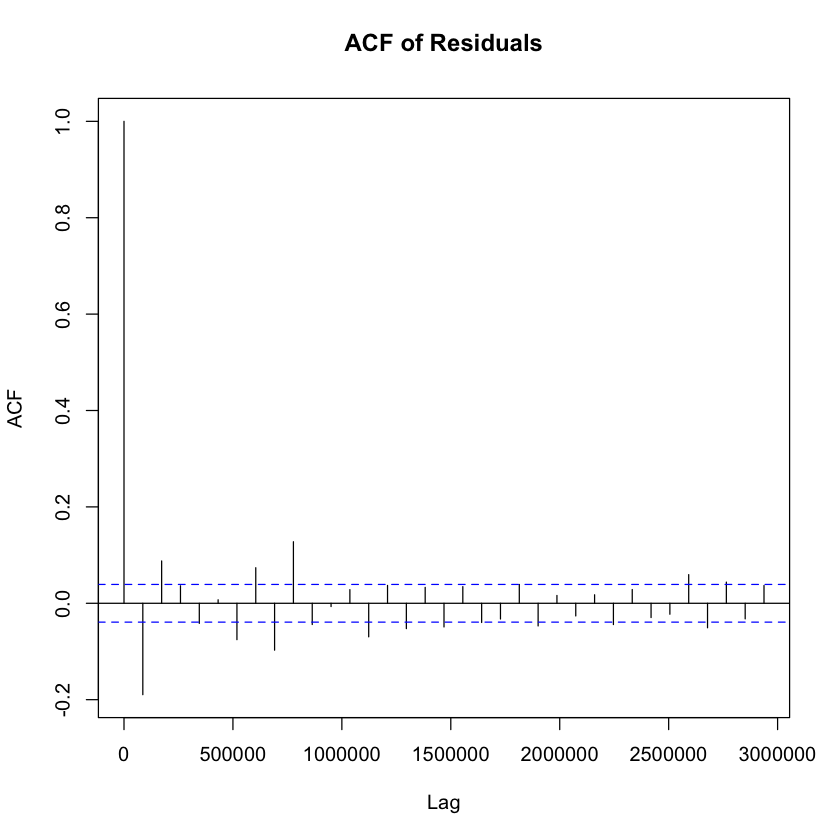


	Box-Ljung test

data:  garch.arma.model.residuals
X-squared = 215.6, df = 10, p-value < 2.2e-16



	Box-Ljung test

data:  garch.arma.model.residuals^2
X-squared = 877.87, df = 10, p-value < 2.2e-16


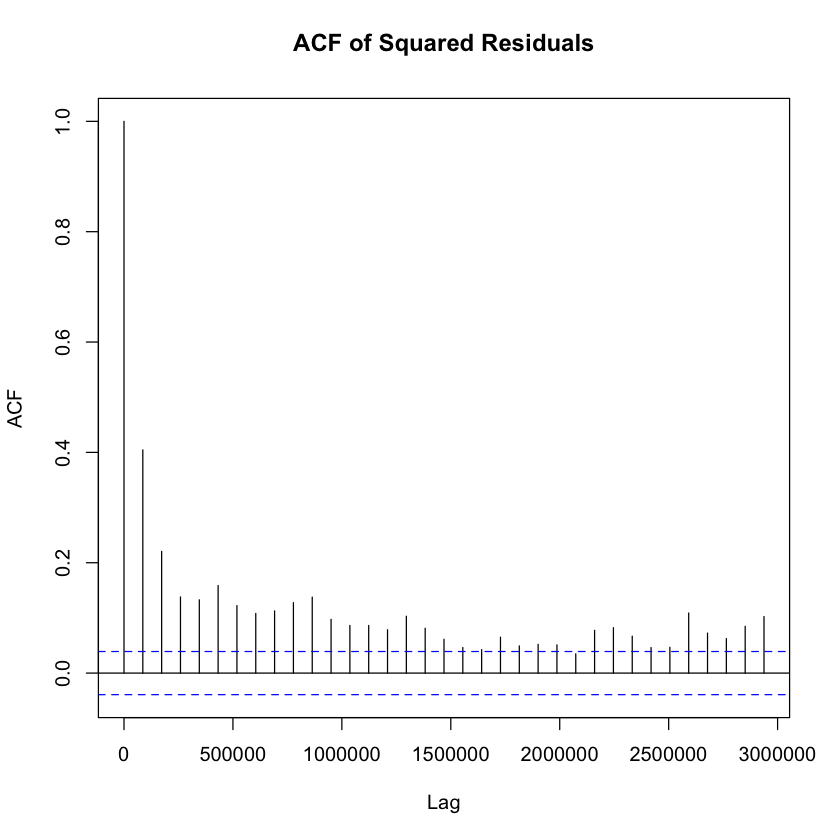

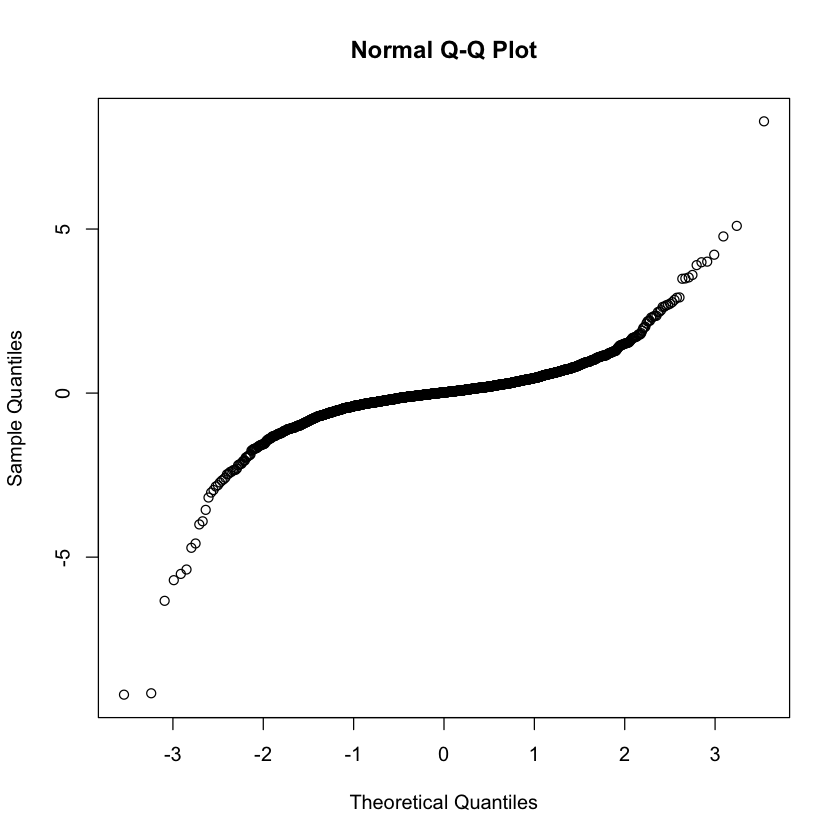

In [55]:
garch.arma.model.residuals = residuals(garch.arma.model)
acf(garch.arma.model.residuals,main="ACF of Residuals")
acf(garch.arma.model.residuals^2,main="ACF of Squared Residuals")
Box.test(garch.arma.model.residuals,lag=10,type='Ljung')
Box.test(garch.arma.model.residuals^2,lag=10,type='Ljung')
qqnorm(garch.arma.model.residuals)

*Response: Question 3b*

**3c.** Apply the model identified in (3a) and forecast the mean and the variance of the last week of data. Plot the predicted data to compare the predicted values to the actual observed ones. Interpret the results, particularly comparing forecast using daily versus weekly data.

*Response: Question 3c*

**3d.** Calculate Mean Absolute Percentage Error (MAPE) and Precision Measure (PM) for the mean forecasts (PM should net be calculated for weekly data).  Compare the accuracy of the predictions for the daily and weekly time series using these two measures.

*Response: Question 3d*

# Question 4: Reflection on the Modeling and Forecasting (10 points) 

Based on the analysis above, discuss the application of ARIMA on the stock price versus the application of ARMA-GARCH on the stock return. How do the models fit the data? How well do the models predict?  How do the models perform when using daily versus weekly data? Would you use one approach over another for different settings? What are some specific points of caution one would need to consider when applying those models?

*Response: Question 4*